# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>
## Exercise Sheet No. 11 — The Kalman filter
---
Submission by: Batuhan, Oezcoemlekci(Matrikelnummer: 6300476) and Aakarsh, Nair( Matrikelnummer: 6546577)

In [3]:
import numpy as np

from matplotlib import pyplot as plt
from numpy.typing import ArrayLike

import scipy.io as sio
import scipy.linalg as sla
import scipy.special as ssp

from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})


import warnings
import logging

logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)
warnings.filterwarnings( "ignore", module = "matplotlib\..*")
                       

# Exercise 11.2 (Coding Exercise) - READ CAREFULLY!

In this exercise, you will implement a Kalman filter.
We will provide code that loads a time series data set on which you will perform an on-line regression task.
The dataset was taken from measurements in seven-degrees-of-freedom SARCOS anthropomorphic robot arm.
Over 44484 time points, positions, velocities, and accelerations were measured at each of the seven joints of the arm.
We will fit a curve to these data in a recursive (and efficient) on-line fashion using the Kalman filter.

#### IMPORTANT:
We provide the data, the code to load the data, AND THE MODEL. DO NOT CHANGE ANYTHING in this code. Below, there will be a line. From there (Section III), your part begins. First take everything we provide in and process it carefully!


# I. The Data

In [4]:
DIM = 7
NUM_DERIV = 2
STATE_DIM = DIM * (NUM_DERIV + 1)

In [5]:
proj_position = np.eye(STATE_DIM)[:DIM, :]
proj_velocity = np.eye(STATE_DIM)[DIM:2*DIM, :]
proj_acceleration = np.eye(STATE_DIM)[2*DIM:, :]

In [6]:
def plot_data(axs, Y):
    assert len(axs) == 3
    N, d = Y.shape
    num_joints = d // 3
    xs = np.arange(N)
    positions = Y @ proj_position.T
    velocities = Y @ proj_velocity.T
    accelerations = Y @ proj_acceleration.T
    for i in range(num_joints):
        axs[0].scatter(xs, positions[:, i], marker="x", s=5, label="joint {}".format(i), color="C{}".format(i))
        axs[1].scatter(xs, velocities[:, i], marker="x", s=5, label="joint {}".format(i), color="C{}".format(i))
        axs[2].scatter(xs, accelerations[:, i], marker="x", s=5, label="joint {}".format(i), color="C{}".format(i))
#     plt.legend()
    return axs

In [7]:
def plot_estimate(axs, kf_means, kf_covs, fctr=1.97):
    assert len(axs) == 3
    N, d = kf_means.shape
    num_joints = d // 3
    xs = np.arange(N)
    m_positions = kf_means @ proj_position.T
    m_velocities = kf_means @ proj_velocity.T
    m_accelerations = kf_means @ proj_acceleration.T
    
    kf_stds = np.array([fctr * np.sqrt(np.diag(C)) for C in kf_covs])
    s_positions = kf_stds @ proj_position.T
    s_velocities = kf_stds @ proj_velocity.T
    s_accelerations = kf_stds @ proj_acceleration.T
    
    for i in range(num_joints):
        axs[0].plot(xs, m_positions[:, i], color="C{}".format(i))
        axs[0].fill_between(xs, m_positions[:, i] - s_positions[:, i], m_positions[:, i] + s_positions[:, i], color="C{}".format(i), alpha=0.4)
        axs[1].plot(xs, m_velocities[:, i], color="C{}".format(i))
        axs[1].fill_between(xs, m_velocities[:, i] - s_velocities[:, i], m_velocities[:, i] + s_velocities[:, i], color="C{}".format(i), alpha=0.4)
        axs[2].plot(xs, m_accelerations[:, i], color="C{}".format(i))
        axs[2].fill_between(xs, m_accelerations[:, i] - s_accelerations[:, i], m_accelerations[:, i] + s_accelerations[:, i], color="C{}".format(i), alpha=0.4)
        
#     plt.legend()
    return axs    

In [8]:
data = Y = sio.loadmat('sarcos_inv.mat')["sarcos_inv"][:, :-7]

In [9]:
data.shape

(44484, 21)

## Now, let's have a look at the entire time series.

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

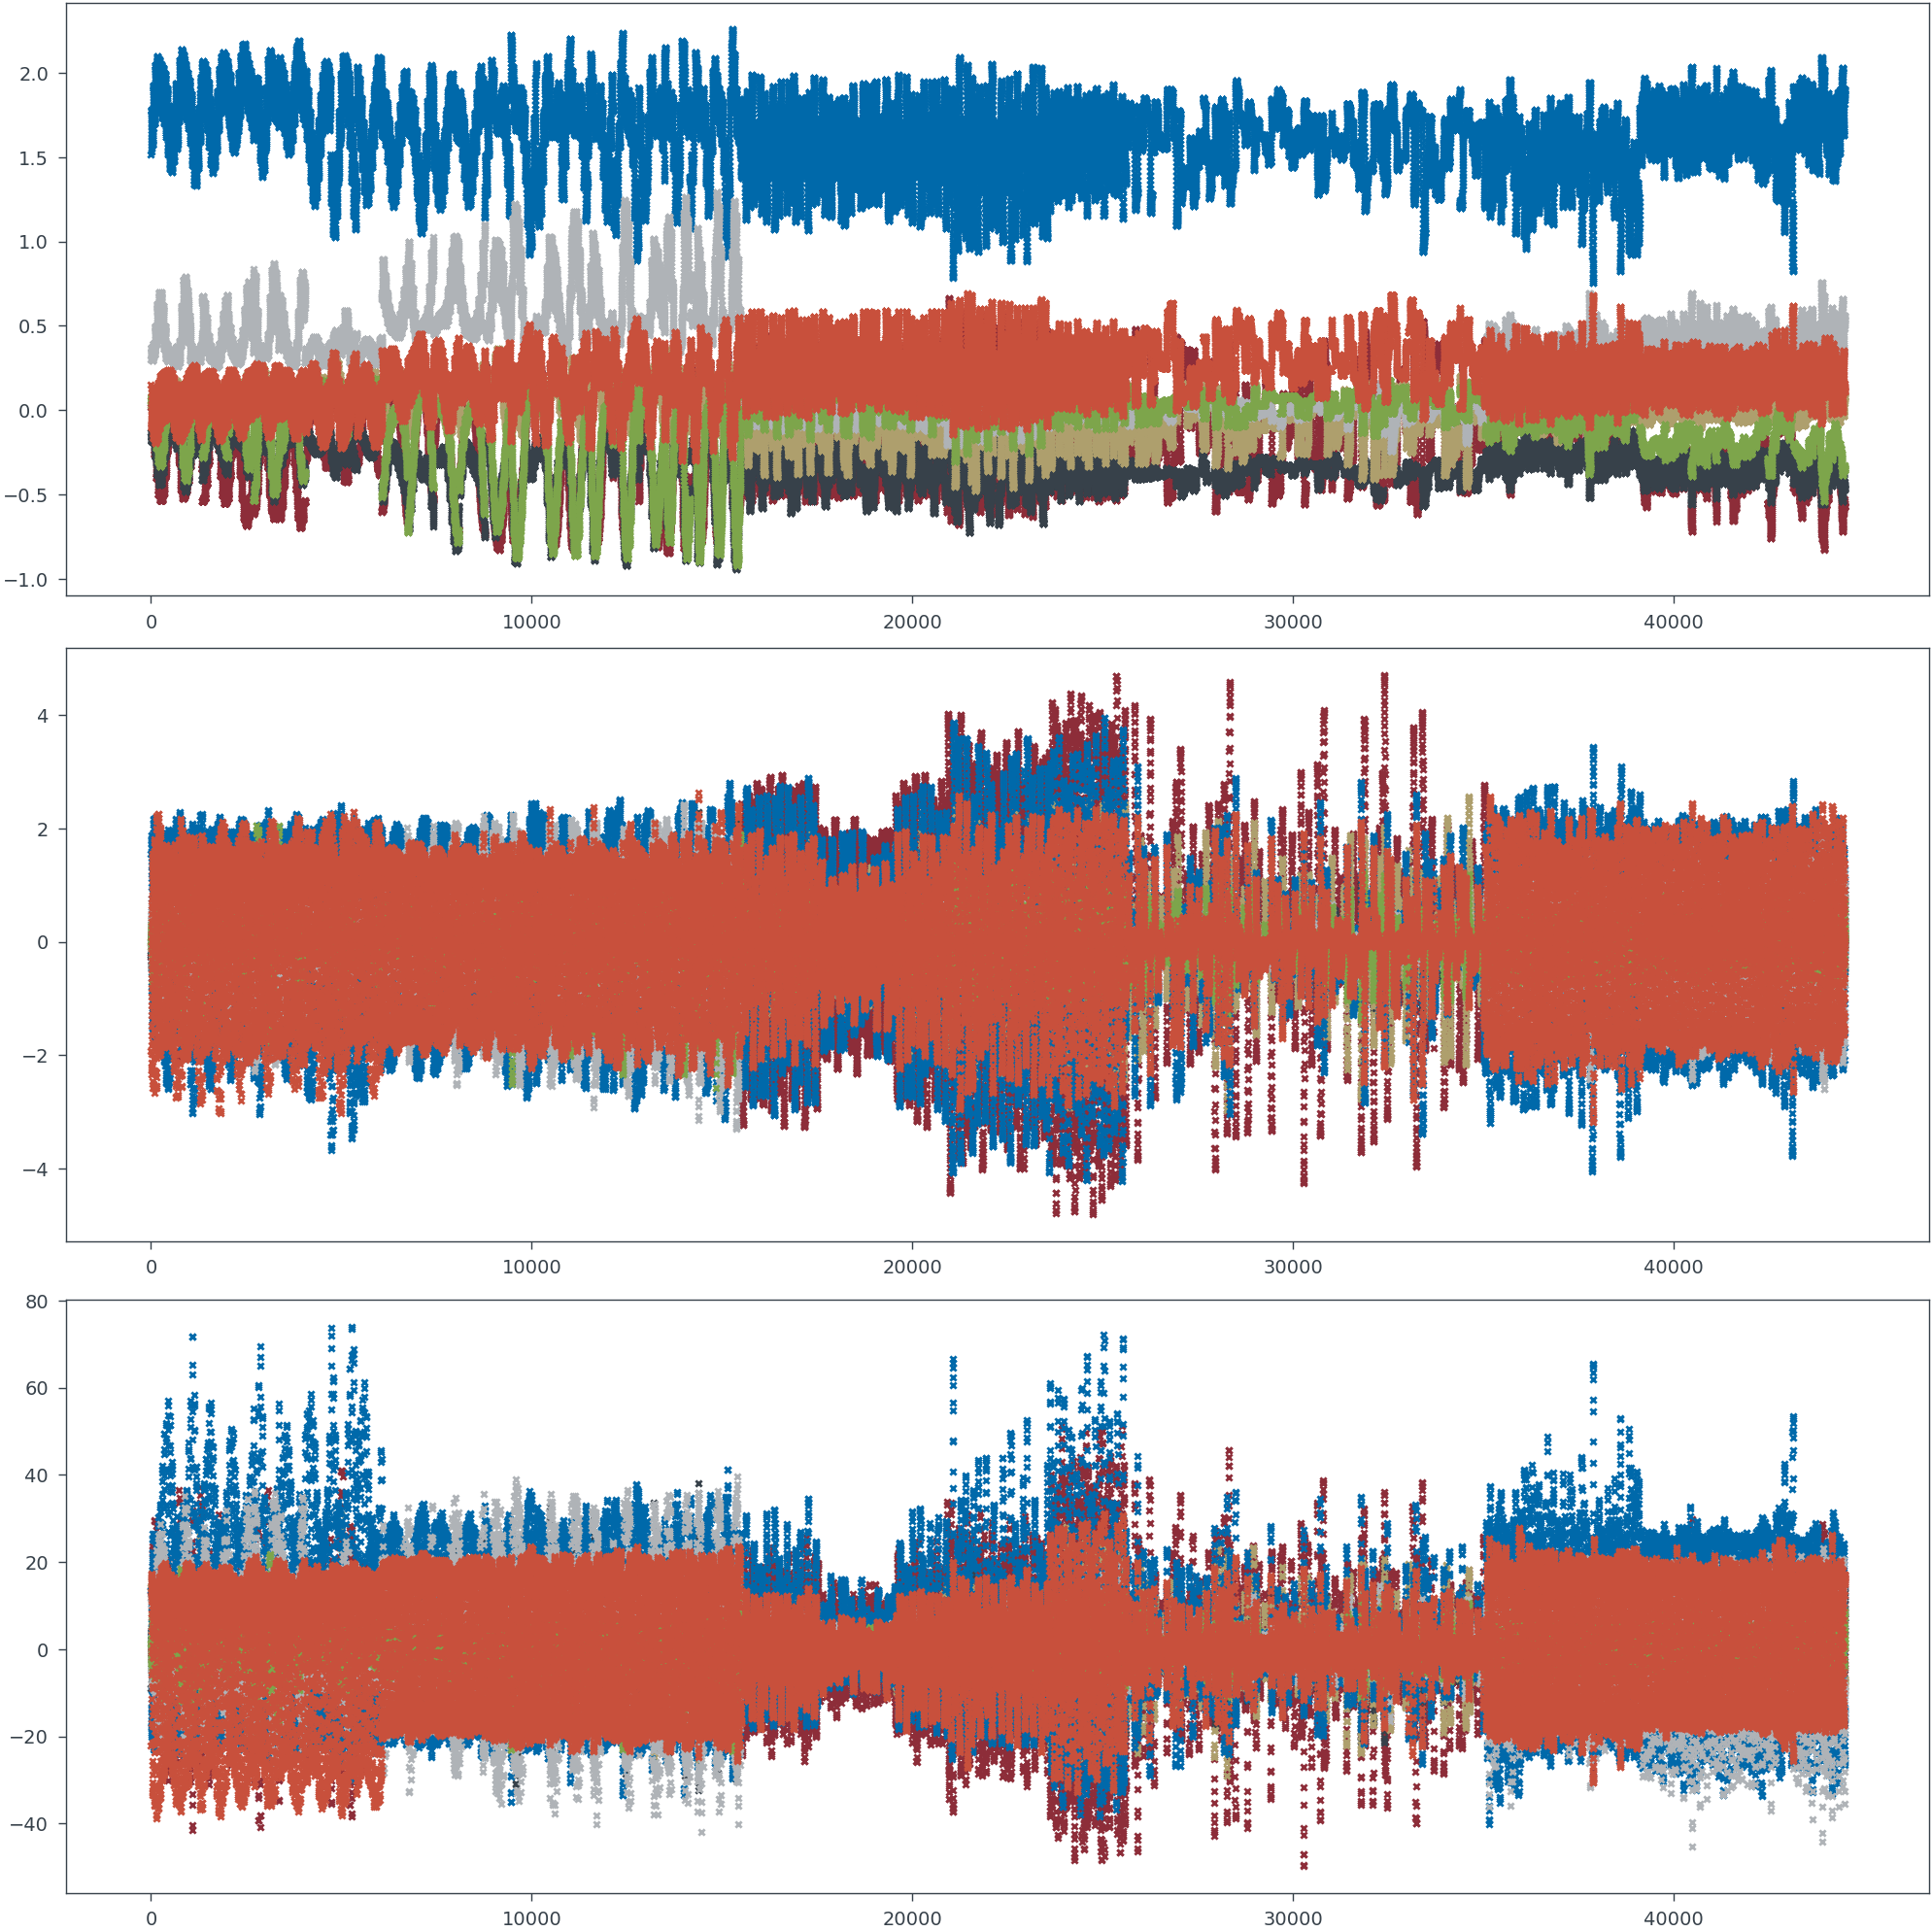

In [10]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_data(axs, Y)

Pretty chaotic, huh... Well, it's over 44 thousand data points and our screen is only so wide... That's why we are going to look at a smaller, zoomed-in window from now on.

In [11]:
time_window_for_viz = slice(11000, 11300)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

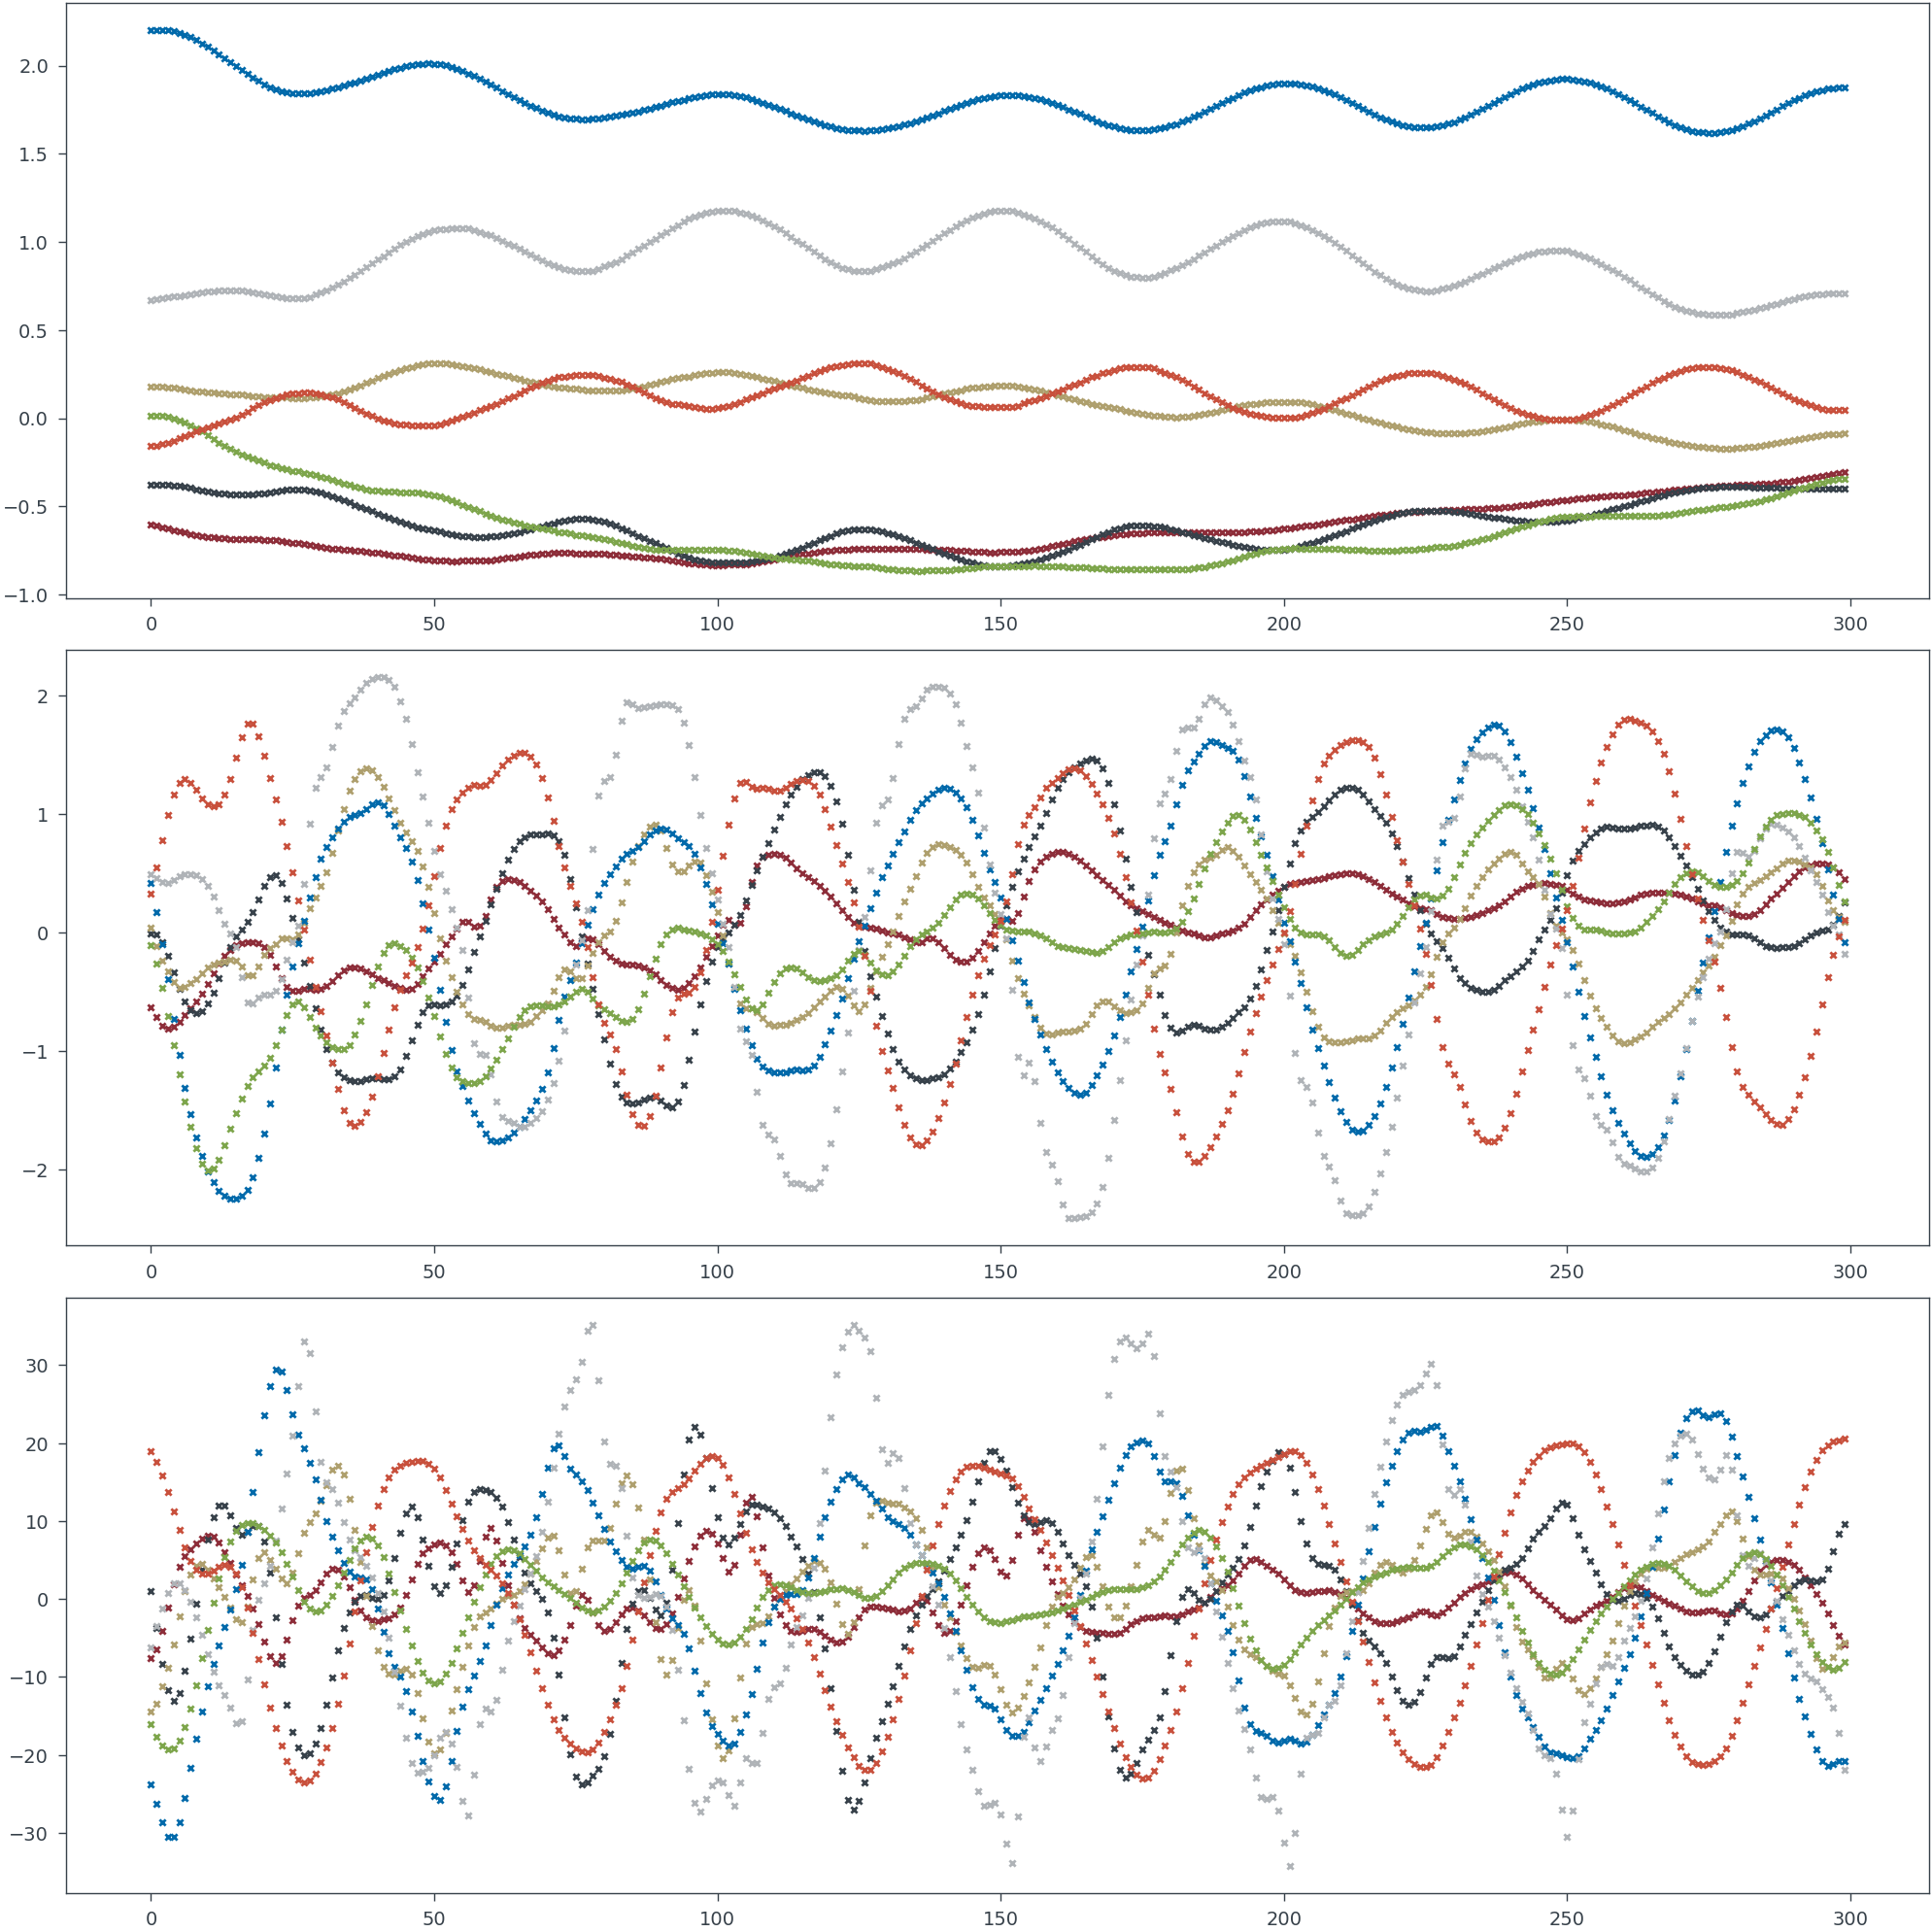

In [12]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_data(axs, Y[time_window_for_viz, :])

# II. The Model

Ok, now that we have a feel for the data and what it looks like, we are going to set up a model.
What kind of model this is, we are going to be secretive about for now. Perhaps, you will learn about it in one of the following lectures? (Perhaps not, let's see).

#### The following two cells ...

... are mysterious functions that create us two matrices $A$ and $Q$, the transition matrix and process-noise covariance matrix of our linear, time-invariant Gaussian transition density.

**You do not have to understand what these two functions do, just take them for granted!** (I wouldn't try, anyway...)

#### The dynamics model (prior)

In [13]:
def mysterious_operation(F, L, dt):
    dim = F.shape[0]

    if L.ndim == 1:
        L = L.reshape((-1, 1))

    Phi = np.block(
        [
            [F, L @ L.T],
            [np.zeros(F.shape), -F.T],
        ]
    )
    M = sla.expm(Phi * dt)

    Ah = M[:dim, :dim]
    Qh = M[:dim, dim:] @ Ah.T

    return Ah, Qh

In [14]:
def create_mysterious_ssm(d, q, ell, dt, dff=1.0):
    F = np.diag(np.ones(q), 1)
    nu = q + 0.5
    D, lam = q + 1, np.sqrt(2 * nu) / ell
    F[-1, :] = np.array(
            [-ssp.binom(D, i) * lam ** (D - i) for i in range(D)]
        )
    
    L = np.eye(q+1)[-1, :] * dff
    A_1d, Q_1d = mysterious_operation(F, L, dt)
    A = np.kron(A_1d, np.eye(d))
    Q = np.kron(Q_1d, np.eye(d))
    return A, Q

In [15]:
dt = 1.0

In [16]:
A, Q = create_mysterious_ssm(DIM, NUM_DERIV, 10.0, dt, 50.0)

#### The measurement model (likelihood)

In [17]:
H = np.eye(STATE_DIM)  # We measure the entire state.
R = np.kron(np.diag(np.array([0.01, 0.01, 1.0])), np.eye(DIM))  # a (not-quite isotropic) sensor noise.

Finally, we set the initial moments to the first data point with some uncertainty.

In [18]:
m0 = Y[0, :]
P0 = np.kron(np.diag(np.array([0.01, 0.01, 1.0])), np.eye(DIM))

---

^--- DO NOT CHANGE ANYTHING ABOVE THIS LINE

# III. Inference (your turn)

Ok, finally. The setup for state-space model sometimes takes its sweet time, that's something you have to get used to if you work with them. But it pays, as we'll see later.

### Now, your task is ...

... to implement a **Kalman filter**.

#### (a)

Implement a naive **pure numpy-based** version of the Kalman filter. Keep it simple, but **do not use** `*.inv`, i.e. **do not invert any matrices, solve linear systems, instead!**

Fill the function bodies of the following two functions `kf_predict` and `kf_update`.
The must each return a tuple.
- `kf_predict` takes 
  - $m_{t-1}$, the previous filtering mean
  - $P_{t-1}$, the previous filtering covariance
  - the transition model, i.e. matrices $A$ and $Q$.
- `kf_predict` returns a tuple $(m_{t}^-, P_{t}^-$) , i.e., the predicted moments.


- `kf_update` takes 
  - $m_{t}^-$, the predicted mean
  - $P_{t}^-$, the predicted covariance
  - the measurement model, i.e. matrices $A$ and $Q$
  - the current data point $y_t$.
- `kf_update` returns a tuple $(m_{t}, P_{t}$) , i.e., the update (filtering) moments.


In [19]:
def kf_predict(m_filt, P_filt, A, Q):
    """
    :param m_filt: The previous filtering mean
    :param P_filt: The previous filtering covariance
    :param A: The state transition matrix
    :param Q: The state transition covariance
    """
    m_pred = A @ m_filt
    P_pred = A @ P_filt @ A.T + Q
    return m_pred, P_pred

In [20]:
def kf_update(m_pred, P_pred, H, R, y, solver=np.linalg.solve):
   """
   :param predicted mean
   :param predicted covariance
   :param measurement matrix
   """
   K_gain = P_pred @ H.T @ solver(H @ P_pred @ H.T + R, np.eye(H.shape[0]))
   z_residual = y - H @ m_pred
   m_filt = m_pred + K_gain @ z_residual
   P_filt = (np.eye(P_pred.shape[0]) - K_gain @ H) @ P_pred
   return m_filt, P_filt

Fill the function body of the following function, which takes the initial moments $m_0, P_0$, the state-sapce model $A, Q, H, R$ and the entire data set $Y$, which is a matrix in $\mathbb{R}^{N \times d}$, where $N$ is the number of data points and $d$ is the measurement dimension.

## IMPORTANT:

Note that we set the initial conditions earlier to match the first data point. So you want to exclude the first data point when implementing the filtering loop. Do include the initial moments into the solution, though!

`filter_kalman` takes the initial moments $m_0, P_0$, the state space model $A, Q, H, R$, and the data set as a ($N \times d$)-matrix.
It returns a tuple of two arrays $M \in \mathbb{R}^{N \times D}, C \in \mathbb{R}^{N \times D \times D}$. $M$ is the matrix that holds the filtered means over time, and $P$ holds the filtered covariance matrices over time.
**THIS IS IMPORTANT!!** If the return types differ, you will not get a point, because the tests will fail.

In [21]:
def filter_kalman(m0, P0, A, Q, H, R, Y):
    num_data_points = Y.shape[0]
    m, P = m0, P0
    m_ret = np.zeros((num_data_points, m0.shape[0]))
    P_ret = np.zeros((num_data_points, P0.shape[0], P0.shape[1]))
    for i in range(num_data_points):
        m_pred, P_pred = kf_predict(m, P, A, Q)
        m, P = kf_update(m_pred, P_pred, H, R, Y[i, :])
        m_ret[i, :] = m 
        P_ret[i, :, :] = P
    return m_ret, P_ret 

# Now we test your implementation.

**DO NOT CHANGE ANYTHING IN THESE CELLS**

In [22]:
%%time
kf_means, kf_covs = filter_kalman(m0, P0, A, Q, H, R, Y)

CPU times: user 51.5 s, sys: 3.82 s, total: 55.3 s
Wall time: 5.97 s


In [23]:
display(kf_means.shape)

(44484, 21)

In [24]:
display(kf_covs.shape)

(44484, 21, 21)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

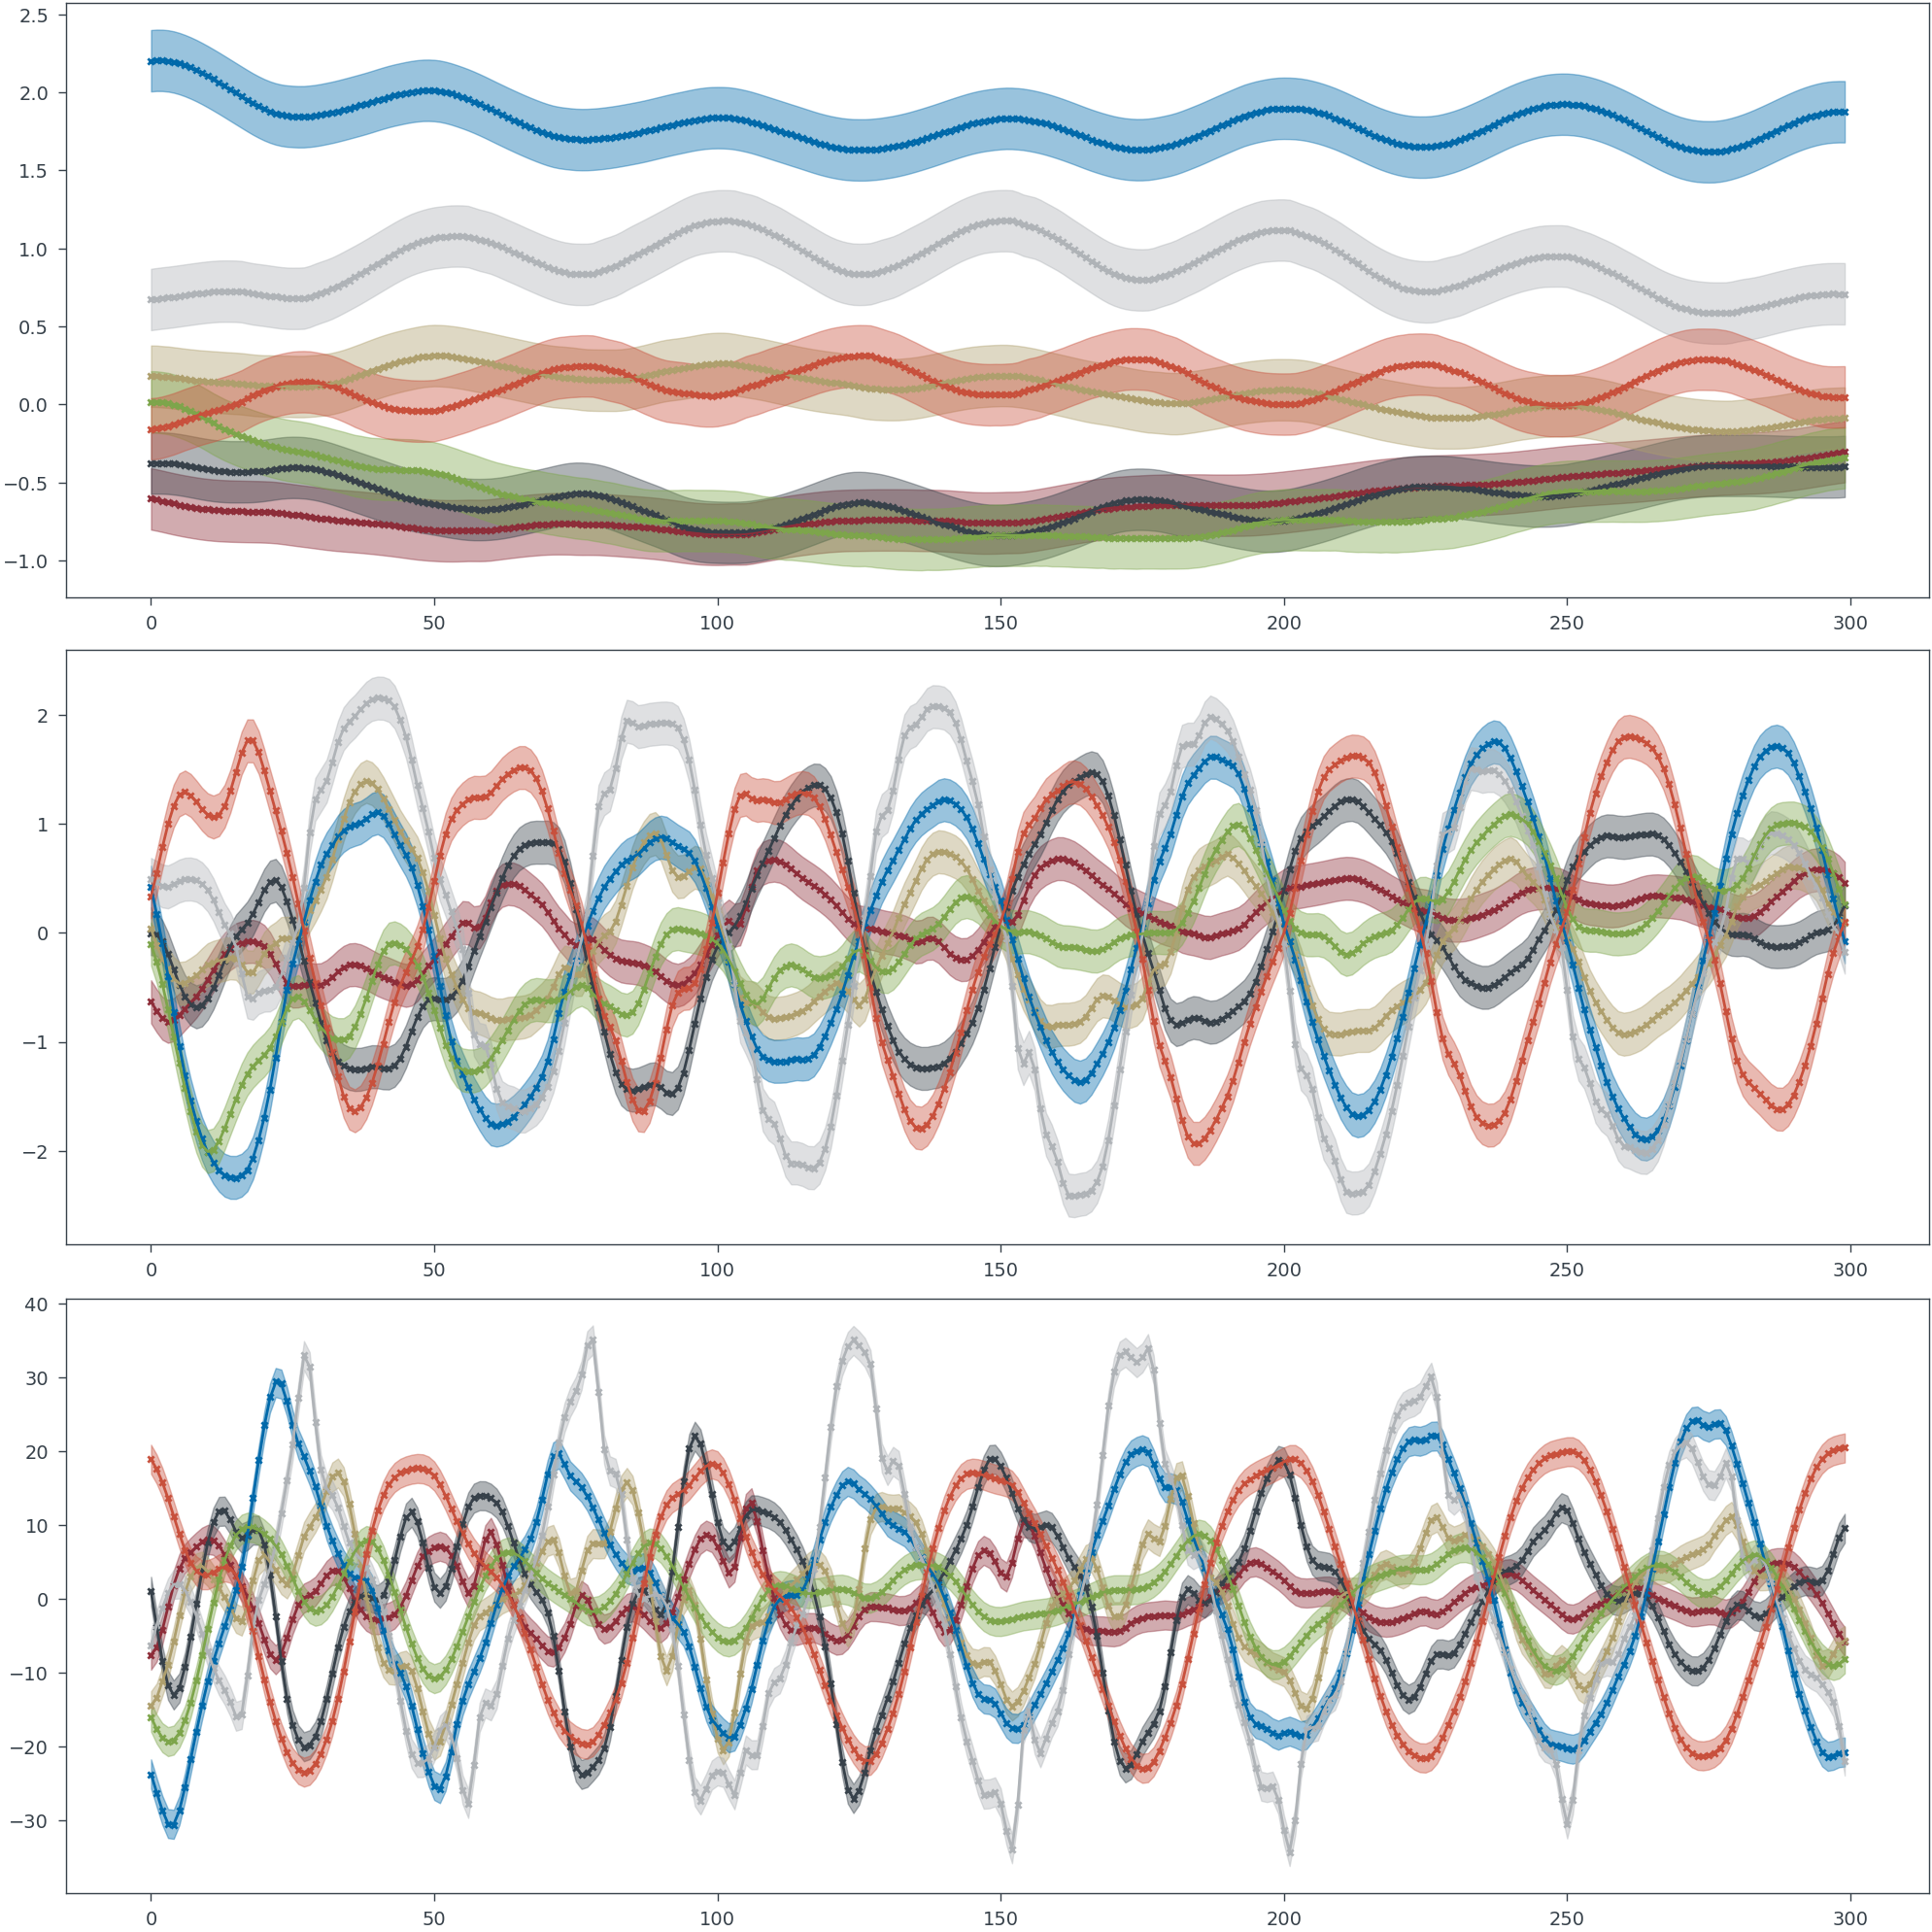

In [25]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_estimate(axs, kf_means[time_window_for_viz, :], kf_covs[time_window_for_viz, :, :])
plot_data(axs, Y[time_window_for_viz, :])

#### (b)

So far so good.
Now, we are going to make this even faster, by using JAX (in a smart way).

In [26]:
import jax
from jax import numpy as jnp
from jax import lax
import jax.scipy.linalg as sla

In [27]:
A, Q = jnp.array(A), jnp.array(Q)

In [28]:
m0, P0 = jnp.array(m0), jnp.array(P0)

In [29]:
H, R = jnp.array(H), jnp.array(R)

In [30]:
Y = jnp.array(Y)

#### First of all, ...

... we note that the previous implementation still works, ....

In [31]:
%%time
kf_means, kf_covs = filter_kalman(m0, P0, A, Q, H, R, Y)

CPU times: user 11min 31s, sys: 42.7 s, total: 12min 14s
Wall time: 1min 11s


... but it's **super slow** ... because this is not a smart way to use JAX.

Therefore...

#### your next task (b) is to ...

... implement a Kalman filter (using `kf_predict` and `kf_update` from above) but this time based on a `scan` operation over the data set.
You can read about that [here (https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)

Implement the function `filter_kalman_scan` below.
The function's input- and output signature is exactly the same as for `filter_kalman`.

In [32]:
def filter_kalman_scan(m0, P0, A, Q, H, R, Y):
    def kf_predit_update_scan(carry_prev, y):   
        m_prev, P_prev = carry_prev
        m_pred, P_pred = kf_predict(m_prev, P_prev, A, Q)
        m, P = kf_update(m_pred, P_pred, H, R, y, solver=jnp.linalg.solve)
        return (m, P), (m, P) 

    carry, outputs = jax.lax.scan(kf_predit_update_scan, (m0, P0), Y)
    num_data_points = Y.shape[0]
    state_dim = m0.shape[0]
    assert (num_data_points, state_dim) == outputs[0].shape
    assert (num_data_points, state_dim, state_dim) == outputs[1].shape
    return  outputs

In [33]:
%%time
kf_means, kf_covs = filter_kalman_scan(m0, P0, A, Q, H, R, Y)

CPU times: user 1.88 s, sys: 208 ms, total: 2.09 s
Wall time: 1.52 s


Woop, woop, it's fast.

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

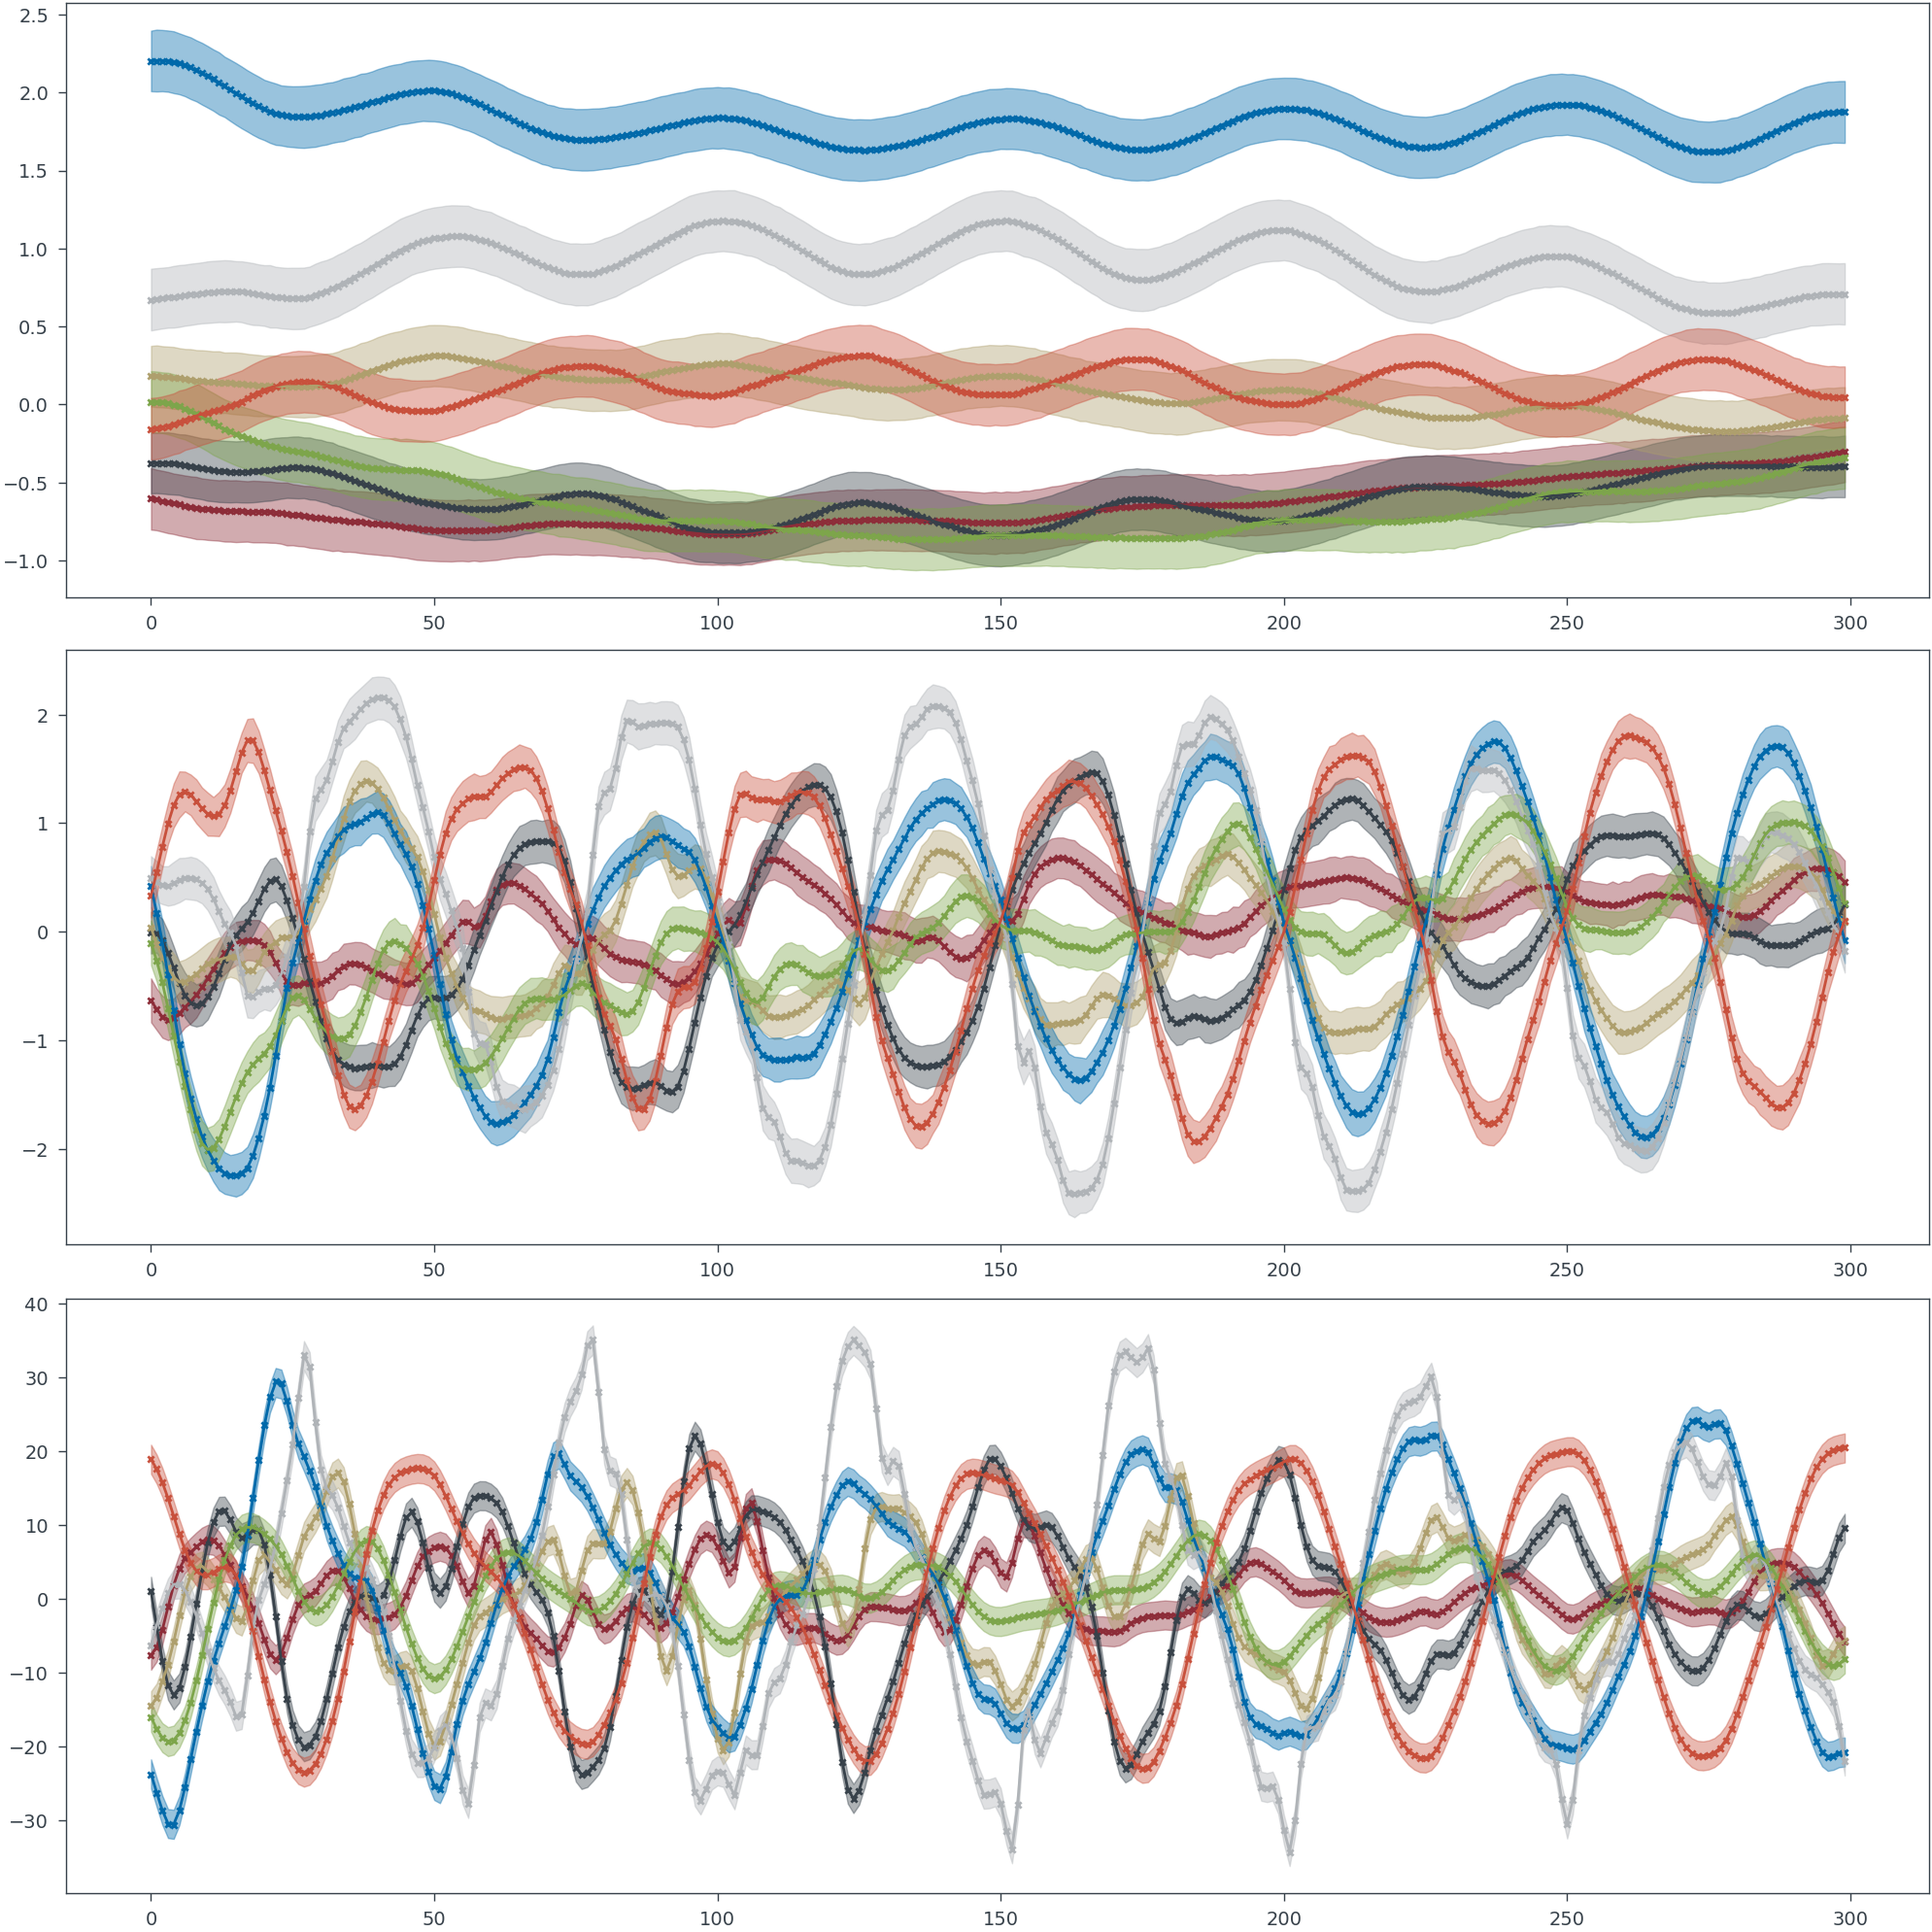

In [34]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_estimate(axs, kf_means[time_window_for_viz, :], kf_covs[time_window_for_viz, :, :])
plot_data(axs, Y[time_window_for_viz, :])

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matrikel number(s) above!)**